# Interpolation methods

This example compares various interpolation methods available when resizing.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali as dali
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path
import PIL

test_data_root = os.environ["DALI_EXTRA_PATH"]
db_folder = os.path.join(test_data_root, "db", "lmdb")

## Downscaling
First, let's define a pipeline that dowscales images aggressively to a fixed size using different interpolation methods:

In [2]:
batch_size = 32

pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(
        path=db_folder, random_shuffle=True, seed=1234
    )
    images = dali.fn.decoders.image(files, device="mixed")

    width = 100
    height = 100

    resize_outs = (
        dali.fn.resize(
            images,
            resize_x=width,
            resize_y=height,
            interp_type=interp,
            antialias=antialias,
        )
        for interp, antialias in [
            (dali.types.INTERP_LINEAR, False),
            (dali.types.INTERP_LINEAR, True),
            (dali.types.INTERP_CUBIC, False),
            (dali.types.INTERP_CUBIC, True),
            (dali.types.INTERP_GAUSSIAN, False),
            (dali.types.INTERP_GAUSSIAN, True),
            (dali.types.INTERP_LANCZOS3, False),
            (dali.types.INTERP_LANCZOS3, True),
            (dali.types.INTERP_NN, False),
        ]
    )

    pipe.set_outputs(images, *resize_outs)

pipe.build()
pipe_out = pipe.run()

Let's define a utility for diplaying the output images

In [3]:
def show(pipe_out, idx, methods, figsize=(16, 32)):
    from synsets import imagenet_synsets
    import matplotlib.gridspec as gridspec

    len_outputs = len(pipe_out)
    fig = plt.figure(figsize=figsize)
    plt.suptitle(None)
    columns = 2
    rows = int(math.ceil(len_outputs / columns))
    gs = gridspec.GridSpec(rows, columns)
    for i in range(len_outputs):
        plt.subplot(gs[i])
        plt.axis("off")
        plt.title(methods[i])
        pipe_out_cpu = pipe_out[i].as_cpu()
        img_chw = pipe_out_cpu.at(idx)
        plt.imshow((img_chw) / 255.0)

Original image


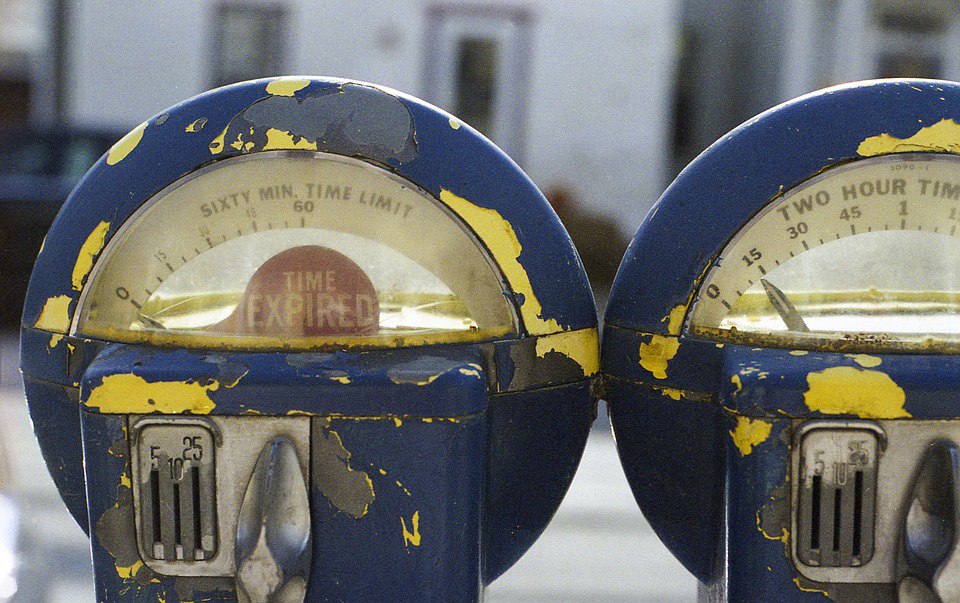

In [4]:
print("Original image")
PIL.Image.fromarray(pipe_out[0].as_cpu().at(5))

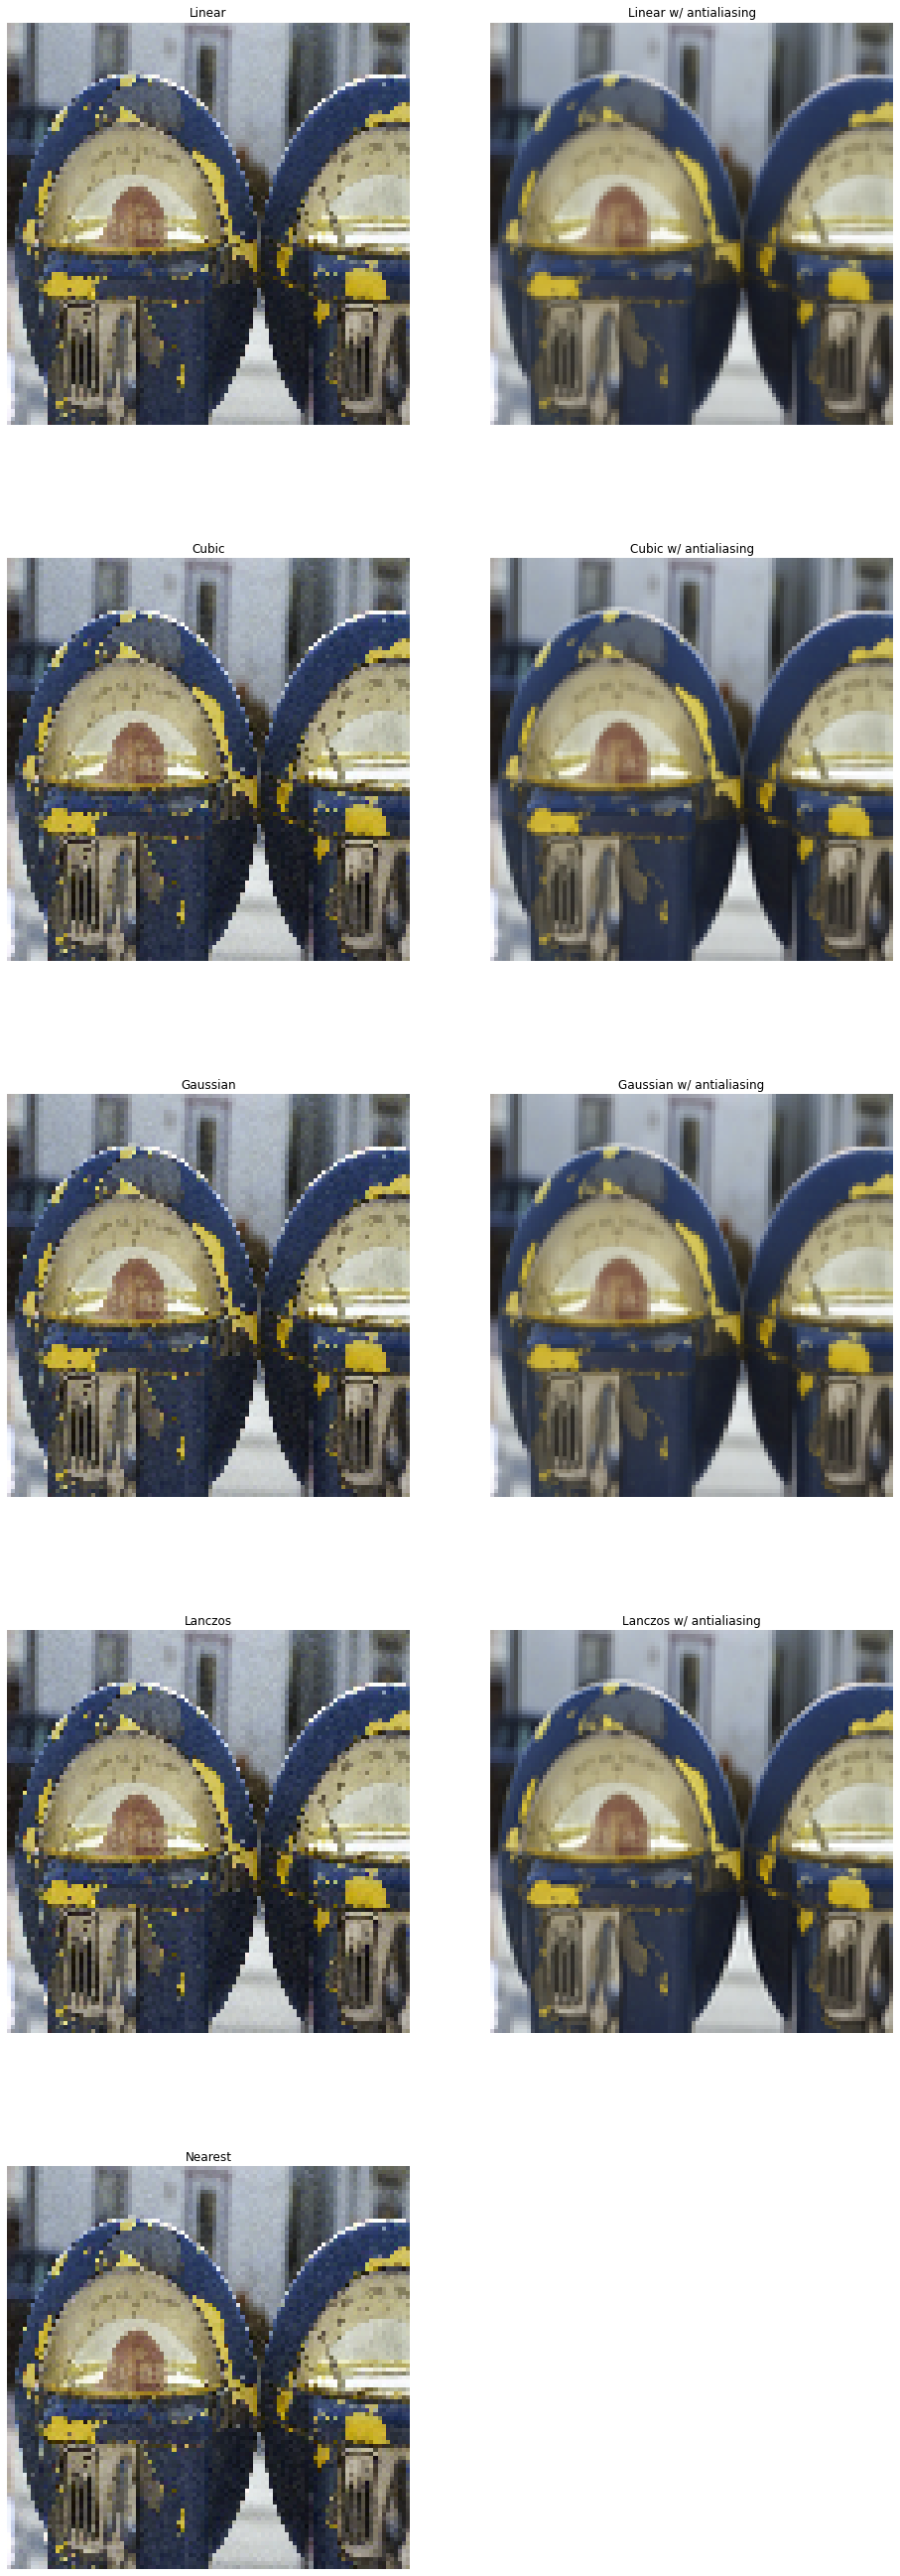

In [5]:
methods = [
    "Linear",
    "Linear w/ antialiasing",
    "Cubic",
    "Cubic w/ antialiasing",
    "Gaussian",
    "Gaussian w/ antialiasing",
    "Lanczos",
    "Lanczos w/ antialiasing",
    "Nearest",
]
show(pipe_out[1:], 5, methods, figsize=(16, 48))

As we can clearly see, interpolations without anti-aliasing are not suitable for aggreesive downscaling.

## Upscaling
Now, let's compare how the interpolation methods fare at upscaling. For good visualization, we'll take a small crop of the input.

In [6]:
batch_size = 32

pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(
        path=db_folder, random_shuffle=True, seed=1234
    )
    images = dali.fn.decoders.image(files, device="mixed")

    width = 400
    height = 400

    cropped = dali.fn.crop(images, crop=(150, 150))

    nearest, linear, cubic, gaussian, lanczos = (
        dali.fn.resize(
            cropped, resize_x=width, resize_y=height, interp_type=interp
        )
        for interp in [
            dali.types.INTERP_LINEAR,
            dali.types.INTERP_CUBIC,
            dali.types.INTERP_GAUSSIAN,
            dali.types.INTERP_LANCZOS3,
            dali.types.INTERP_NN,
        ]
    )

    pipe.set_outputs(cropped, nearest, linear, cubic, gaussian, lanczos)

pipe.build()
pipe_out = pipe.run()

[/home/janton/git/dali/dali/operators/image/resize/resampling_attr.cc:97] The default behavior for LINEAR interpolation type has been changed to apply an antialiasing filter. If you didn't mean to apply an antialiasing filter, please use `antialias=False`


Original image


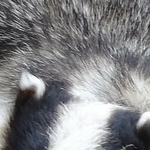

In [7]:
print("Original image")
PIL.Image.fromarray(pipe_out[0].as_cpu().at(1))

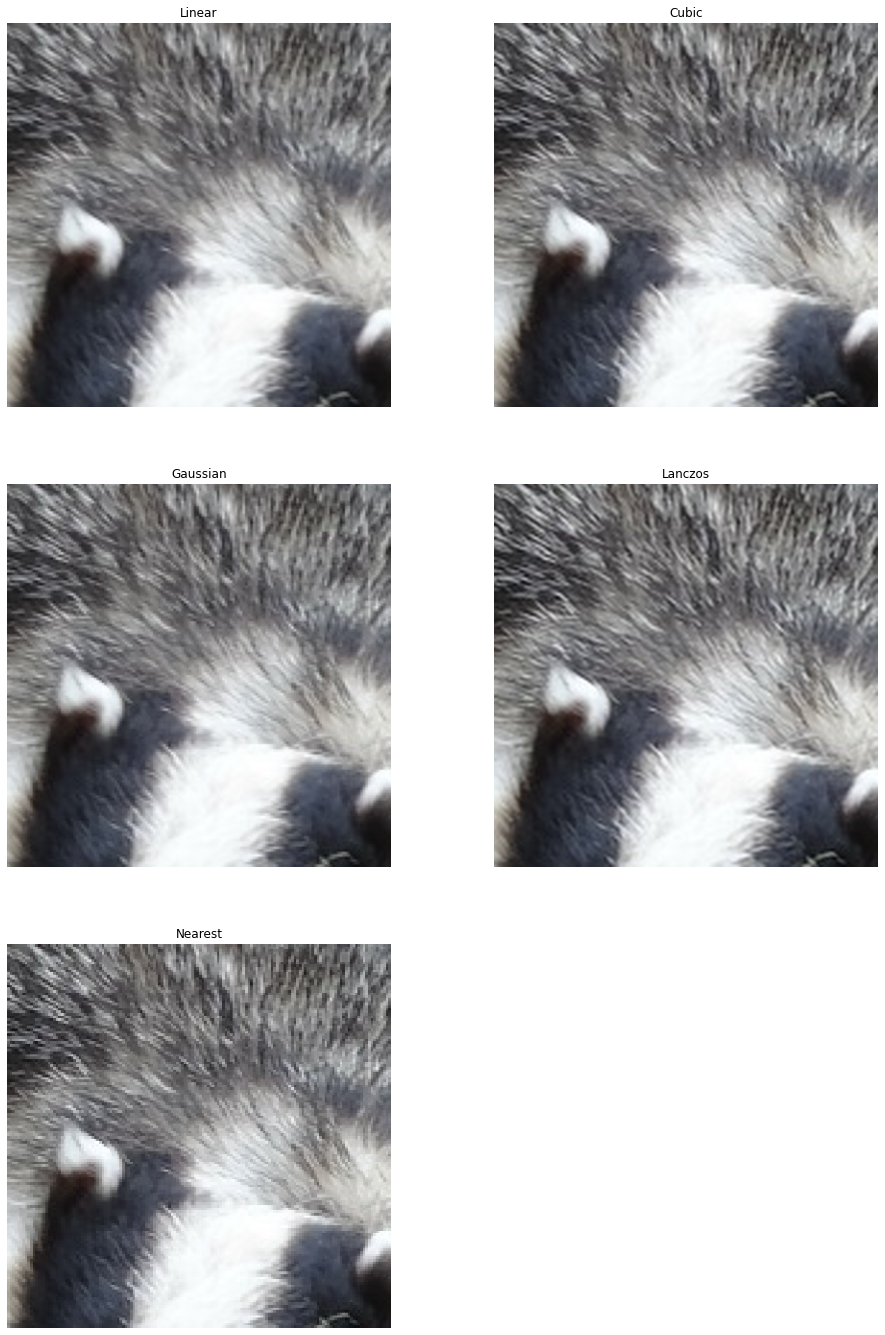

In [8]:
methods = ["Linear", "Cubic", "Gaussian", "Lanczos", "Nearest"]
show(pipe_out[1:], 1, methods, figsize=(16, 24))

As expected, nearest neighbor interpolation produces severe block artifacs. More sophisticated filters produce far better results, but require more computational power.